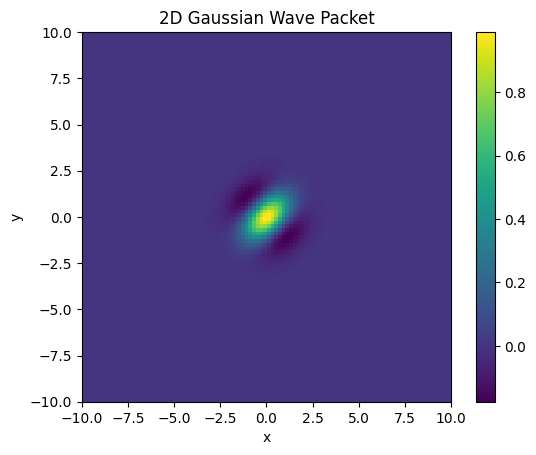

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def two_dimensional_gaussian_wave_packet(x, y, x0, y0, sigma_x, sigma_y, kx, ky, A):
    envelope = np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2)))
    phase = np.exp(1j * (kx * x + ky * y))
    wave_packet = A * envelope * phase
    return wave_packet

# Example usage
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
wave_packet = two_dimensional_gaussian_wave_packet(X, Y, 0, 0, 1, 1, 1, 1, 1)

plt.imshow(np.real(wave_packet), extent=[-10, 10, -10, 10])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Gaussian Wave Packet')
plt.show()
